In [93]:
import cv2
import numpy as np
import math

def round_to_nearest_odd(number):
    """
    Round a given number to the nearest odd integer.

    Parameters:
    number (float): The number to be rounded.

    Returns:
    int: The nearest odd integer to the given number. If the number is equidistant 
         between two odd integers, it rounds up if the number is positive and down if negative.
    """
    rounded_number = round(number)
    if rounded_number % 2 == 0:
        if number >= rounded_number:
            return rounded_number + 1
        else:
            return rounded_number - 1
    return rounded_number

def find_main_circle(image, standard_image_size=512, standard_kernel_size=15, low_search_part=0.25, high_search_part=0.75):
    """
    Detect the main circle in the given image using the Hough Circle Transform.

    Parameters:
    - image: Input image in which to detect the circle.
    - standard_image_size: Standard size to which the image is resized for processing if it is smaller.
    - standard_kernel_size: Optimal kernel size for standart size image to remove all unnecessary details using median blurring.
    - low_search_part: Lower bound for the radius search range as a fraction of the radius of the inscribed circle in the image's bounding box.
    - high_search_part: Upper bound for the radius search range as a fraction of the radius of the inscribed circle in the image's bounding box.

    Returns:
    - circles[0]: The detected circle parameters (x, y, radius) if found, otherwise None.
    """

    # Determine the minimum dimension of the image
    image_size = min(image.shape[:2])
    
    # Image will be resized if it is smaller than the standard size
    is_resized = image_size < standard_image_size
    
    # Define scale factor
    scale_factor = 1.0
    
    # Resize the image if necessary
    if is_resized:
        scale_factor = standard_image_size / image_size
        new_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
        image_size = min(image.shape[:2])
    
    # Calculate the kernel size for median blurring
    kernel_size = round_to_nearest_odd(standard_kernel_size * image_size / standard_image_size)
    
    # Apply median blur to the image
    blurred_image = cv2.medianBlur(image, kernel_size)
    
    otsu, threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if otsu == 0:
        otsu = 1
    
    # Perform Hough Circle Transform to detect circles
    circles = cv2.HoughCircles(
        blurred_image, 
        cv2.HOUGH_GRADIENT, 
        dp=1,  # The inverse ratio of the accumulator resolution to the image resolution. A value of 1 means the accumulator has the same resolution as the input image.
        minDist=max(image_size, standard_image_size),  # Minimum distance between the centers of the detected circles. This is set to the size of the image to avoid detecting multiple nearby circles.
        param1=otsu,#high_thresh,  # Higher threshold for the Canny edge detector. A lower value is chosen to detect more edges.
        param2=1,  # Accumulator threshold for the circle centers at the detection stage. A lower value means more circles will be detected.
        minRadius=int(low_search_part * max(image_size, standard_image_size) / 2),  # <-┐
        maxRadius=int(high_search_part * max(image_size, standard_image_size) / 2)  # <-┴ These values were chosen because the desired circle is presumably within this size range.
    )

    # Check if any circles were found
    if circles is None:
        return None

    # Rescale the circle parameters to the original image size
    if is_resized:
        circles[0][0][0] /= scale_factor
        circles[0][0][1] /= scale_factor
        circles[0][0][2] /= scale_factor
    
    # Return the detected circle parameters
    return circles[0][0]

def get_points(image, circle, wall_thickness = 16, circles_ratio = 0.1):
    """
    Extracts points from the given image within a specified circular region.

    This function performs the following steps:
    1. Denoises the image using Fast Non-Local Means Denoising.
    2. Creates a mask with a circular region of interest.
    3. Applies the mask to the denoised image.
    4. Normalizes the pixel values within the masked region.
    5. Thresholds the image using Otsu's method to create a binary image.
    6. Removes all pixels outside the mask.
    7. Creates a secondary mask to define a wall thickness around the circle.
    8. Uses flood fill to remove unwanted regions within the binary image.
    9. Finds contours in the binary image.
    10. Extracts the center points of the contours.

    Parameters:
    image (numpy.ndarray): The input image from which points are to be extracted.
    circle (tuple): A tuple containing the (x, y) coordinates and radius of the circle.
    wall_thickness (int, optional): The thickness of the wall around the circle to be considered. Default is 15.
    circles_ratio (float, optional): The ratio of the inner circle radius to the outer circle radius. Default is 0.1.

    Returns:
    list: A list of (x, y) coordinates representing the center points of the detected contours.
    """
        
    # Denoise the image using Fast Non-Local Means Denoising
    denoise_image = cv2.fastNlMeansDenoising(image)

    # Create a mask with a circular region of interest
    mask = np.zeros_like(denoise_image)
    cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circle[2]), 255, -1)
    cv2.circle(mask, (round(circle[0]), round(circle[1])), round(circles_ratio*circle[2]), 0, -1)

    # Apply the mask to the denoised image
    masked_image = cv2.bitwise_and(denoise_image, denoise_image, mask=mask)
    
    # Normalize the pixel values within the masked region
    loc = np.where(mask == 255)
    min_val = np.min(masked_image[loc])
    max_val = np.max(masked_image[loc])
    masked_image[loc] = np.clip((masked_image[loc].astype(int) - min_val)*255/(max_val - min_val), 0, 255).astype(np.uint8)

    # Threshold the image using Otsu's method to create a binary image
    otsu, binary_image = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Set everything outside the mask to black
    binary_image[mask == 0] = 0

    # Create a secondary mask to define a wall thickness around the circle
    circle_mask = np.zeros_like(binary_image)
    cv2.circle(circle_mask, (round(circle[0]), round(circle[1])), round(circle[2]), 255, wall_thickness)

    # Get the pixels within the wall thickness
    circle_pixels = np.where(circle_mask == 255)

    # Create a fill mask for flood fill operation
    fill_mask = np.zeros((binary_image.shape[0]+2, binary_image.shape[1]+2), dtype=np.uint8)

    # Use flood fill to remove unwanted regions within the binary image
    for y, x in zip(circle_pixels[0], circle_pixels[1]):
        if binary_image[y, x] == 255:
            cv2.floodFill(binary_image, None, (x,y), 0)
            
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the center points of the contours
    points = []
    for contour in contours:
        ((cX, cY), _, _) = cv2.minAreaRect(contour)
        points.append((cX, cY))
        
    # Return points
    return points

def segmentation(mri_images, ct_images, size_for_resizing=2048, wall_thickness=4, circles_ratio=0.1, low_search_part=0.25, high_search_part=0.75):
    """
    Segments MRI and CT images to extract points of interest.

    This function processes each slice of MRI and CT images, detects the main circle in each slice,
    and extracts points of interest within a specified circular region.

    Parameters:
    mri_images (numpy.ndarray): 3D array of MRI images.
    ct_images (numpy.ndarray): 3D array of CT images.
    size_for_resizing (int, optional): Size to which each image slice is resized for processing. Default is 2048.
    wall_thickness (int, optional): Thickness of the wall around the circle to be considered. Default is 4.
    circles_ratio (float, optional): Ratio of the inner circle radius to the outer circle radius. Default is 0.1.
    low_search_part (float, optional): Lower bound for the radius search range as a fraction of the radius of the inscribed circle in the image's bounding box. Default is 0.25.
    high_search_part (float, optional): Upper bound for the radius search range as a fraction of the radius of the inscribed circle in the image's bounding box. Default is 0.75.

    Returns:
    tuple: A tuple containing two lists:
        - all_mri_points (list): List of points extracted from MRI images.
        - all_ct_points (list): List of points extracted from CT images.
    """
    
    # Check if the number of slices in MRI and CT images are the same
    if mri_images.shape[2] != ct_images.shape[2]:
        return 'Error: MRI and CT data have different number of images.'
    
    # Initialize lists to store points from MRI and CT images
    all_mri_points = []
    all_ct_points = []
    
    # Process each slice of MRI and CT images
    for i in range(mri_images.shape[2]):
        # DEBUG
        print(f"{i} from {mri_images.shape[2]}")
        
        mri_image = mri_images[:, :, i] # Extract the i-th slice from MRI images
        ct_image = ct_images[:, :, i] # Extract the i-th slice from CT images
        
        # Calculate scaling factors for resizing images
        scale_mri_factor = size_for_resizing/min(mri_image.shape[:2])
        scale_ct_factor = size_for_resizing/min(ct_image.shape[:2])
        
        # Resize MRI and CT images to the specified size
        mri_image = cv2.resize(mri_image, (size_for_resizing, size_for_resizing), interpolation=cv2.INTER_CUBIC)
        ct_image = cv2.resize(ct_image, (size_for_resizing, size_for_resizing), interpolation=cv2.INTER_CUBIC)

        # Detect the main circle in the resized MRI and CT images
        mri_circle = find_main_circle(mri_image, low_search_part=low_search_part, high_search_part=high_search_part)
        ct_circle = find_main_circle(ct_image, low_search_part=low_search_part, high_search_part=high_search_part)
        
        # Extract points of interest from the MRI and CT images within the detected circles
        mri_points = get_points(mri_image, mri_circle, wall_thickness=int(wall_thickness*scale_mri_factor), circles_ratio=circles_ratio)
        ct_points = get_points(255-ct_image, ct_circle, wall_thickness=int(wall_thickness*scale_ct_factor), circles_ratio=circles_ratio)
        
        # Append the extracted points to the respective lists
        all_mri_points.append(np.array(mri_points)/scale_mri_factor)
        all_ct_points.append(np.array(ct_points)/scale_ct_factor)
    
    # Return the lists of points extracted from MRI and CT images
    return all_mri_points, all_ct_points

Пример использования

In [94]:
import nibabel as nib
import numpy as np

input_file_mri = './MRI_warped.nii.gz'
input_file_ct = './CT_fixed.nii.gz'

img_mri = nib.load(input_file_mri)
img_mri_data = img_mri.get_fdata()
img_mri = img_mri_data[:, :, :].copy()
img_mri = img_mri + np.abs(np.min(img_mri))
img_mri *= 255.0 / (np.max(img_mri) + 1e-5)
img_mri = img_mri.astype(np.uint8)

img_ct = nib.load(input_file_ct)
img_ct_data = img_ct.get_fdata()
img_ct = img_ct_data[:, :, :].copy()
img_ct = img_ct + np.abs(np.min(img_ct))
img_ct *= 255.0 / (np.max(img_ct) + 1e-5)
img_ct = img_ct.astype(np.uint8)

all_mri_points, all_ct_points = segmentation(img_mri[:,:,45:105], img_ct[:,:,45:105])

0 from 60
1 from 60
2 from 60
3 from 60
4 from 60
5 from 60
6 from 60
7 from 60
8 from 60
9 from 60
10 from 60
11 from 60
12 from 60
13 from 60
14 from 60
15 from 60
16 from 60
17 from 60
18 from 60
19 from 60
20 from 60
21 from 60
22 from 60
23 from 60
24 from 60
25 from 60
26 from 60
27 from 60
28 from 60
29 from 60
30 from 60
31 from 60
32 from 60
33 from 60
34 from 60
35 from 60
36 from 60
37 from 60
38 from 60
39 from 60
40 from 60
41 from 60
42 from 60
43 from 60
44 from 60
45 from 60
46 from 60
47 from 60
48 from 60
49 from 60
50 from 60
51 from 60
52 from 60
53 from 60
54 from 60
55 from 60
56 from 60
57 from 60
58 from 60
59 from 60


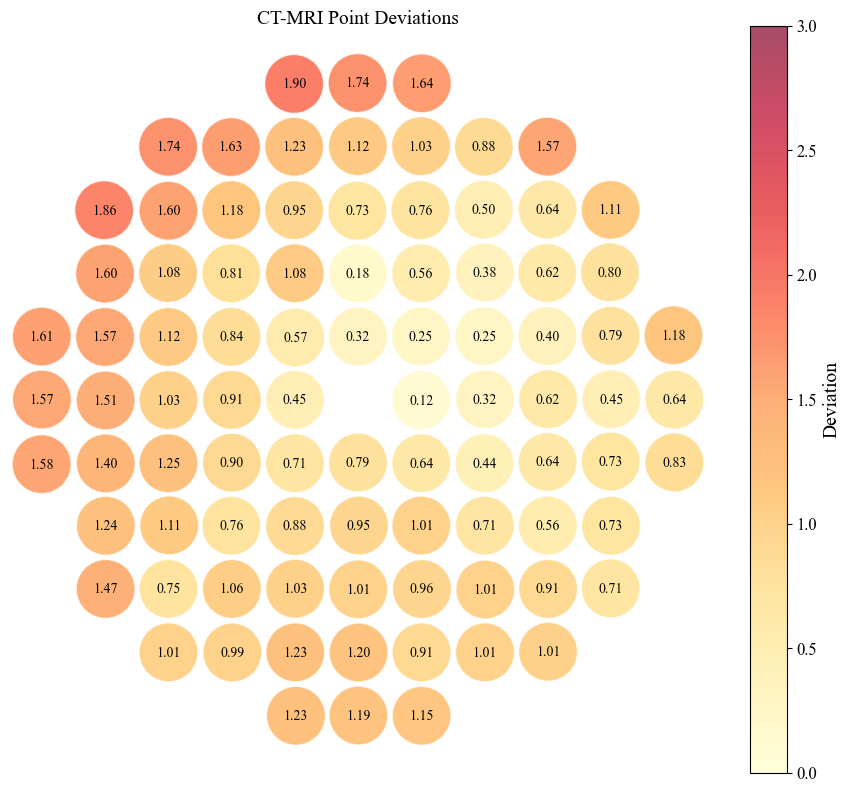

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns

def plot_2D_colormap(all_mri_points, all_ct_points, slice, max_deviation = 3):
    # Set the style
    plt.style.use('default')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'

    # Create the figure
    fig, ax = plt.subplots(figsize=(9, 8))
    fig.patch.set_alpha(0)
    ax.set_facecolor('none')

    mr_points = np.array(all_mri_points[slice])
    ct_points = np.array(all_ct_points[slice])

    # Build KD-tree for nearest neighbor search
    tree = cKDTree(ct_points)
    distances, indices = tree.query(mr_points)

    # Reorder CT points to match nearest MR points
    ct_points = ct_points[indices]

    deviations = np.linalg.norm(mr_points - ct_points, axis=1)

    # Create scatter plot
    scatter = ax.scatter(ct_points[:, 0], ct_points[:, 1], c=deviations, 
                        cmap='YlOrRd', s=1800, alpha=0.7, edgecolors='w')

    # Add text labels for deviations
    for i, (x, y, d) in enumerate(zip(ct_points[:, 0], ct_points[:, 1], deviations)):
        ax.text(x, y, f'{d:.2f}', ha='center', va='center', 
                color='black', fontsize=10)

    # Modify the colorbar
    cbar = plt.colorbar(scatter)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Deviation', fontsize=14)

    # Set colorbar limits
    scatter.set_clim(0, max_deviation)

    # Customize the plot
    ax.set_aspect('equal')
    ax.set_title('CT-MRI Point Deviations', fontsize=14, pad=20)
    ax.axis('off')

    # Add a light background color
    fig.patch.set_facecolor('#F0F0F0')

    plt.tight_layout()
    plt.savefig('CT-MR_Point_Deviations.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    
plot_2D_colormap(all_mri_points, all_ct_points, 25)

In [98]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import cKDTree

def plot_3D_rods(all_mri_points, all_ct_points, max_deviation = 3):
    # Предполагаем, что coords_mr и coords_ct уже определены
    coords_mr = np.array(all_mri_points)
    coords_ct = np.array(all_ct_points)

    # Инициализация списков для 3D точек и их отклонений для Plotly
    mr_x, mr_y, mr_z = [], [], []
    ct_x, ct_y, ct_z = [], [], []
    dev_x, dev_y, dev_z, dev_colors = [], [], [], []

    # Проходим через каждый срез
    for z, (slice_mr, slice_ct) in enumerate(zip(coords_mr, coords_ct)):
        mr_points = np.array(slice_mr)
        ct_points = np.array(slice_ct)
        
        # Создаем KD-дерево для поиска ближайших соседей
        tree = cKDTree(ct_points)
        distances, indices = tree.query(mr_points)
        
        # Переупорядочиваем точки CT, чтобы они соответствовали ближайшим точкам MR
        ct_points = ct_points[indices]
        
        deviations = np.linalg.norm(mr_points - ct_points, axis=1)
        
        # Добавляем точки в списки для Plotly
        mr_x.extend(mr_points[:, 0])
        mr_y.extend(mr_points[:, 1])
        mr_z.extend([z] * len(mr_points))
        
        ct_x.extend(ct_points[:, 0])
        ct_y.extend(ct_points[:, 1])
        ct_z.extend([z] * len(ct_points))
        
        dev_x.extend(ct_points[:, 0])
        dev_y.extend(ct_points[:, 1])
        dev_z.extend([z] * len(ct_points))
        dev_colors.extend(deviations)

    # Create the Plotly figure with a light theme
    fig = go.Figure().update_layout(template="plotly_white")

    # Add MR points with a slight transparency for a 3D effect
    fig.add_trace(go.Scatter3d(
        x=mr_x, y=mr_y, z=mr_z,
        mode='markers',
        marker=dict(size=3, color='red', opacity=0.8),
        name='MRI'
    ))

    # Add CT points with a slight transparency for a 3D effect
    fig.add_trace(go.Scatter3d(
        x=ct_x, y=ct_y, z=ct_z,
        mode='markers',
        marker=dict(size=3, color='blue', opacity=0.8),
        name='CT'
    ))

    # Add deviation points with a color bar and adjusted color scale
    fig.add_trace(go.Scatter3d(
        x=dev_x, y=dev_y, z=dev_z,
        mode='markers',
        marker=dict(
            size=3, 
            color=dev_colors, 
            colorscale='YlOrRd',  # Use a warm color scale
            cmin=0, 
            cmax=max_deviation, 
            colorbar=dict(
                title='Deviations',  # Add units to the colorbar title
                tickvals=[i for i in range(max_deviation + 1)],
                ticktext=[f"{i}" for i in range(max_deviation+1)]
            )
        ),
        name='Deviations'
    ))

    # Update layout for better aesthetics and a clean medical look
    fig.update_layout(
        title='3D Visualization of MRI and CT Points',
        scene=dict(
            xaxis_title='X',  # Add units to axis titles
            yaxis_title='Y',
            zaxis_title='Slice',
            bgcolor='white'  # Set background color to white
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            bgcolor='rgba(255, 255, 255, 0.8)',  # Adjust legend background transparency
            bordercolor='rgba(0, 0, 0, 0.5)',
            borderwidth=2
        ),
        font=dict(family="Arial", size=12),  # Use a clean and readable font
        margin=dict(l=0, r=0, b=0, t=40)  # Reduce margins for a cleaner look
    )

    fig.show()

plot_3D_rods(all_mri_points, all_ct_points)